# Xarray-spatial
### User Guide: Classification tools
-----

[Generate terrain](#Generate-Terrain-Data)
[Reclassify](#Reclassify)

-----------


#### Let's use datashader to render our images...

In [1]:
import numpy as np
import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

import xrspatial

## Generate Terrain Data

The rest of the geo-related functions focus on raster data (or rasterized data, after a previous Datashader step that returns an Xarray object). To demonstrate using these raster-based functions, let's generate some fake terrain as an elevation raster:

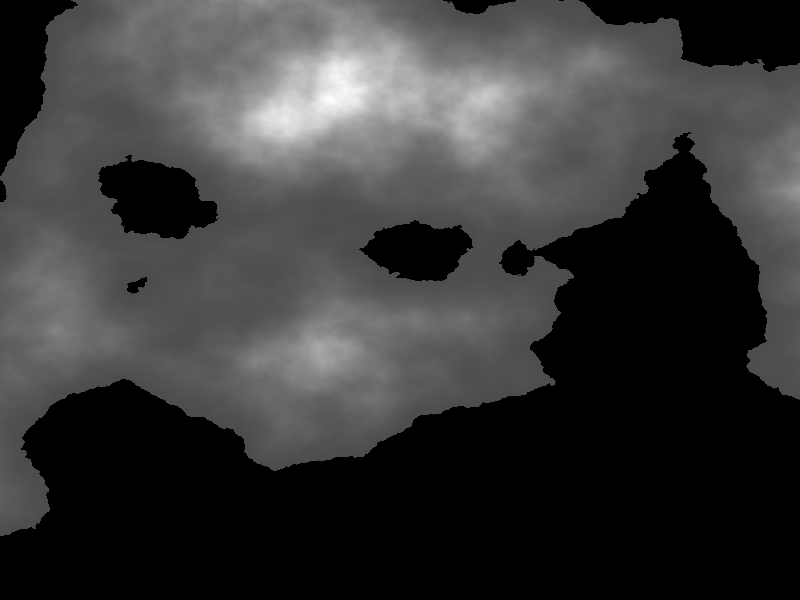

In [2]:
from xrspatial import generate_terrain

W = 800
H = 600

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20e6, 20e6), y_range=(-20e6, 20e6))
terrain = generate_terrain(canvas=cvs)

shade(terrain, cmap=['black', 'white'], how='linear')

## Reclassify

### Quantile Reclassify

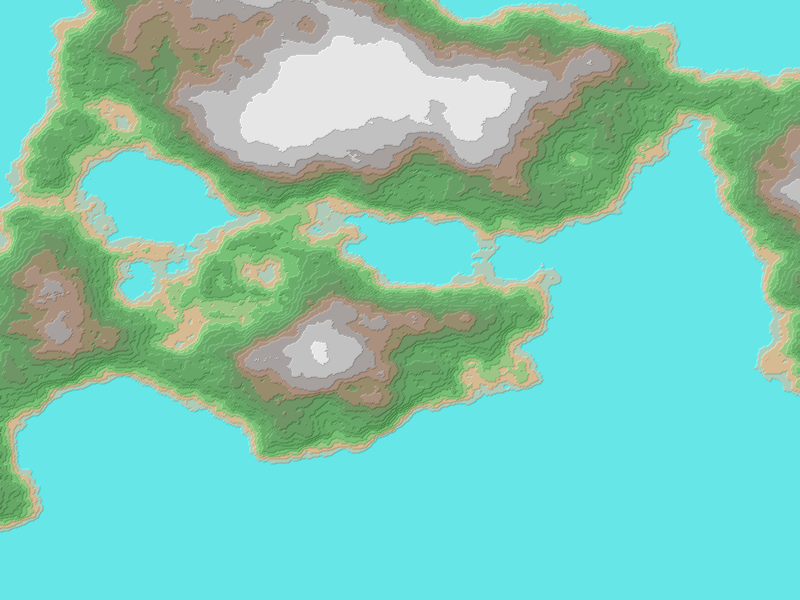

In [3]:
from xrspatial import hillshade
from xrspatial import quantile

qcut_agg = quantile(terrain, k=15, ignore_vals=(0,))

stack(shade(hillshade(qcut_agg), cmap=['gray', 'white'], alpha=255, how='linear'),
      shade(qcut_agg,     cmap=Elevation,         alpha=128, how='linear'))

### Equal Interval Reclassify

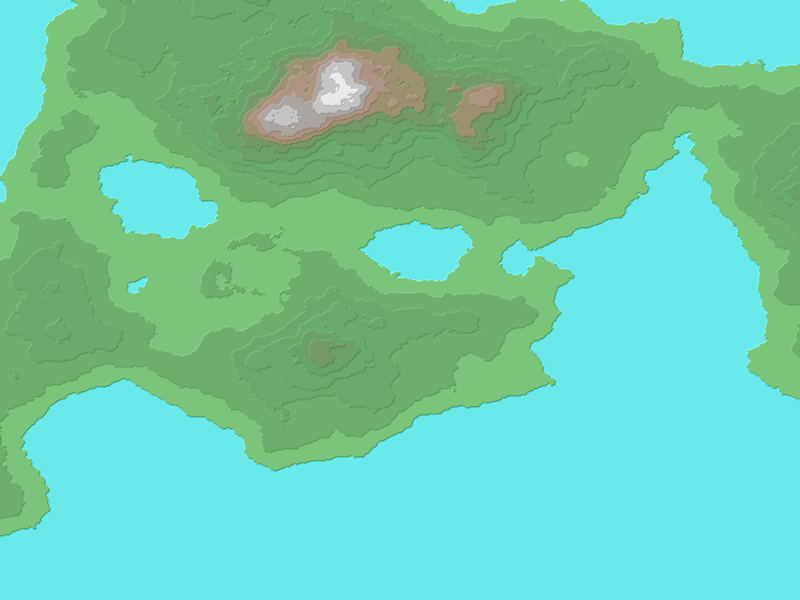

In [4]:
from xrspatial.classify import equal_interval
from xrspatial import hillshade

equal_interval_agg = equal_interval(terrain, k=15)

stack(shade(hillshade(equal_interval_agg), cmap=['gray', 'white'], alpha=255, how='linear'),
      shade(equal_interval_agg, cmap=Elevation, alpha=128, how='linear'))

### Natural Breaks (Jenks) Reclassify

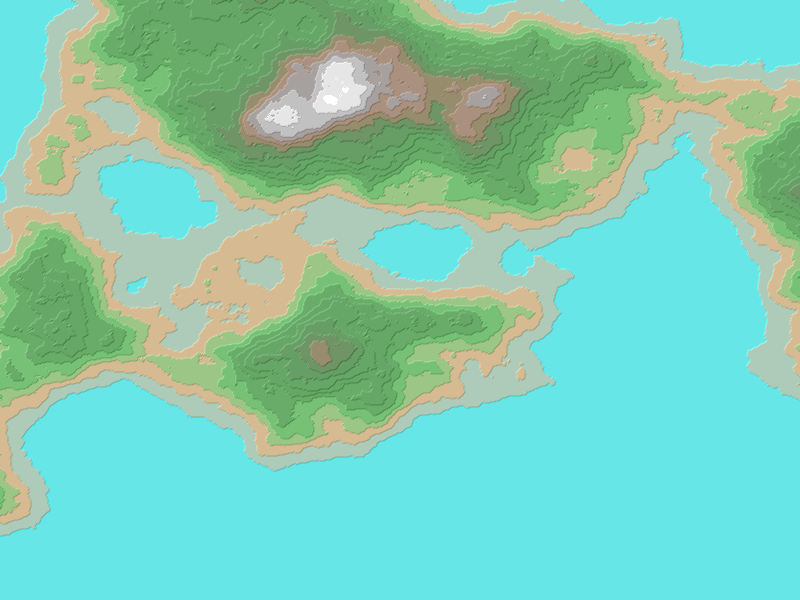

In [5]:
from xrspatial.classify import natural_breaks
from xrspatial import hillshade

natural_breaks_agg = natural_breaks(terrain, num_sample=1000, k=15)

stack(shade(hillshade(natural_breaks_agg), cmap=['gray', 'white'], alpha=255, how='linear'),
      shade(natural_breaks_agg, cmap=Elevation, alpha=128, how='linear'))

### Regions: Groupby Pixel-Value Connectivity

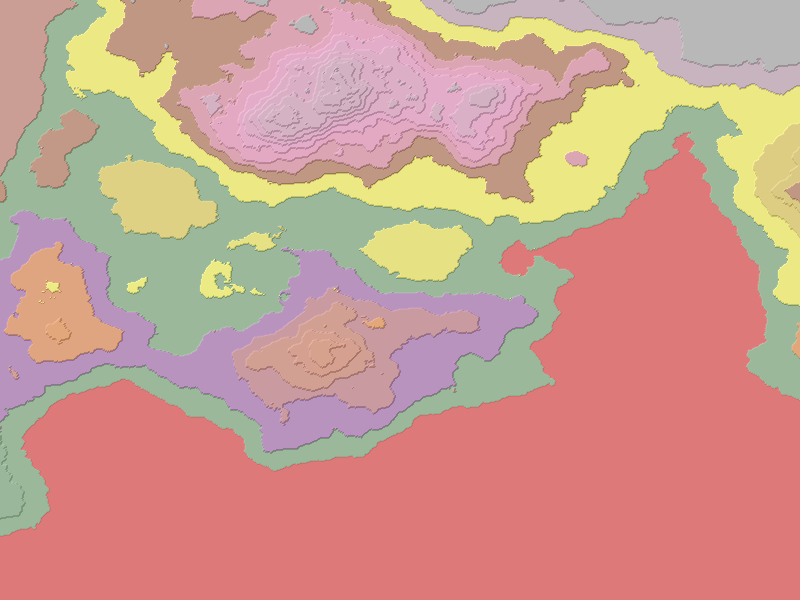

In [6]:
from xrspatial.zonal import regions
from xrspatial import hillshade
from datashader.colors import Set1, Set3

regions_agg = regions(equal_interval_agg, neighborhood=4)

stack(shade(hillshade(regions_agg), cmap=['gray', 'white'], alpha=255, how='linear'),
      shade(regions_agg, cmap=Set1, alpha=128, how='eq_hist'))

In [7]:
from xrspatial import pathfinding
import pandas as pd


df = pd.DataFrame({
   'x': [-13, -11, -5, 4, 9, 11, 18, 6],
   'y': [-13, -5, 0, 10, 7, 2, 5, -5],
   'id': [1, 2, 3, 4, 5, 6, 7, 8]
})

cvs = ds.Canvas(plot_width=W, plot_height=H,
                x_range=(-20, 20), y_range=(-20, 20))




### References
- Burrough, P. A., and McDonell, R. A., 1998. Principles of Geographical Information Systems (Oxford University Press, New York), p. 406.
- Making Maps with Noise Functions: https://www.redblobgames.com/maps/terrain-from-noise/
- How Aspect Works: http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-aspect-works.htm#ESRI_SECTION1_4198691F8852475A9F4BC71246579FAA